20 minute talk, 
15 minutes yapping, 5 minutes questions 

Begin: 
-Give some history.. Talk about NCAR's contribution.. Stovepiped non-interactive
- Py-ART, data model driven design
- A history of the ingests and how one by one ingests have been added.
- Enter wradlib, Use of wradlib code as a low level optional dependancy.. Contrast wradlib and Py-art, Where is the magic? 
- Py-art use inside of DoE, use in radar processing
- Py-ART use outside of DoE, Teaching (Steve), operations (Anderson)
- Py-ART as a dependancy, ART-View.. 
- What is the future, grid data model. 



# <span class="hgviolet">From Zero to Hero in Two Years, Open Collaborative Radar Software and the Secret to our Success</span>

Description:

As computer languages have undergone swift development in recent decades much of the oceanic and atmospheric community has been slow to shift from strongholds such as Fortran. While there has always been a number of open source solutions for the radar meteorology community to process data, projects have been stove-piped. Scientists tend to build applications on top of these software stacks in order to publish and the resultant code often is not used outside of the scientist’s institution or direct collaborators. This presentation will outline an alternate path using community based open source software. We will discuss the Python-ARM Radar Toolkit and recent community success in performing common radar processing tasks by combining multiple tools often written on different continents.




- Scott Collis, Argonne National Laboratory
- Nick Guy, University of Wyoming
- Anderson Gama, SIMEPAR - Sistema Meteorológico do Paraná
- Cesar Beneti, SIMEPAR - Sistema Meteorológico do Paraná
- Stephen Nesbitt, University of Illinois
- Scott Giangrande, Brookhaven National Laboratory
- Maik Hiestermann, University of Potsdam
- Kai Muehlbauer, University of Bonn

<div>
    <img class="logo" src="../images/python-logo.png" height="100" width="250" align="left"/>
    <img class="logo" src="../images/arm_logo.png" height="100" width="250" align="right"/>
</div>
<img class="logo" src="../images/argonne_logo.png" height="100" width="250" align='center'/>



 <hgroup>
      <h2>What is Py-ART?</h2>
      <h3>Py-ART is a data model driven Python based architecture for interacting with radar data</h3>
    </hgroup>
    <article>
  

In [25]:
import pyart
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import numpy as np
%matplotlib inline


In [2]:
radar = pyart.io.read('../data/BRW131207040001.RAWWFAP')
print(radar.metadata)
print(radar.scan_type)


{'comment': '', 'sigmet_task_name': 'NSA_PPI0    ', 'title': '', 'sigmet_extended_header': 'true', 'Conventions': 'CF/Radial instrument_parameters', 'source': '', 'version': '1.3', 'references': '', 'time_ordered': 'none', 'instrument_name': 'xsapr-nsar1', 'rays_missing': 0, 'original_container': 'sigmet', 'institution': '', 'history': ''}
ppi


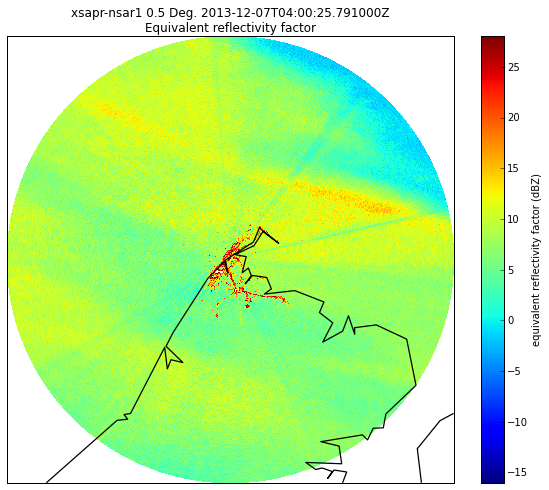

In [3]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 1, resolution = 'i',
                    vmin = -16, vmax = 28)

In [4]:
radar = pyart.io.read('../data/KGYX20150421_095426_V06.gz')
print(radar.metadata)
print(radar.scan_type)
display = pyart.graph.RadarMapDisplay(radar)


{'comment': '', 'title': '', 'Conventions': 'CF/Radial instrument_parameters', 'source': '', 'version': '1.3', 'references': '', 'instrument_name': '', 'original_container': 'NEXRAD Level II', 'institution': '', 'history': ''}
ppi


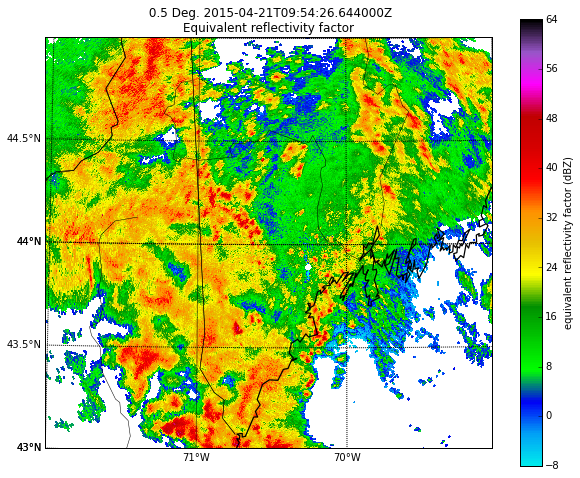

In [5]:
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map( 'reflectivity', vmin = -8, vmax = 64, 
                 resolution = 'i', max_lat = 45, 
                 min_lat = 43, min_lon = -72, max_lon = -69,
                cmap = pyart.graph.cm.NWSRef, mask_outside = False)
m = display.basemap
m.drawparallels(np.linspace(43, 45, 5),labels=[1,0,0,0])
m.drawmeridians(np.linspace(-72, -69, 4),labels=[0,0,0,1])
m.drawrivers()


##Py-ART has:
- Unit testing 
- Continious integration
- Two funded developers, 13 contributors
- Vibrant user community



<img src='../images/network.png' width = 800>

# And then something interesting happened!
### We got organized 

<img src='../images/BAMS.png' width = 800>

| Py-ART                      | wradlib                   | BALTRAD             |
| ----------------------------|:-------------------------:|--------------------:|
| The magic is in the box     | User has to add the magic | Magic is everwhere! |
| Intreactive                 | Interactive               |   Operational       |
| The magic is in the box     | User has to add the magic | Magic is everwhere! |
| Intreactive                 | Interactive               |   Operational       |



#Fuzzy logic using Py-ART and wradlib

In [38]:
import skfuzzy as fuzz
import netCDF4
from scipy import ndimage
from copy import deepcopy
import os
#moment : [[start_up, finish_up, start_down, finish_down], weight]
def cum_score_fuzzy_logic(radar, mbfs = None, 
                          debug = False, ret_scores = False,
                          hard_const = None):
    if mbfs == None:
        second_trip = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
                       'normalized_coherent_power' : [[0,0,.5,.6], 3.0], 
                       'height': [[0,0,5000,8000], 1.0], 
                       'sounding_temperature' : [[-100,-100,100,100], 0.0],
                       'SNR' : [[15,20, 1000,1000],1.0]}

        rain = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[0.94,0.96,1,1], 1.0], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
                       'height': [[0,0,5000,6000], 0.0], 
                       'sounding_temperature' : [[0,3,100,100], 2.0],
                       'SNR' : [[8,10, 1000,1000], 1.0]}

        snow = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
                       'cross_correlation_ratio' : [[0.85,0.9,1,1], 1.0], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-100,-100,0,1.], 2.0],
                       'SNR' : [[8,10, 1000,1000], 1.0]}

        no_scatter = {'differential_phase_texture' : [[90,90,400,400], 0.0], 
                       'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
                       'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-100,-100,100,100], 0.0],
                       'SNR' : [[-100,-100, 8,10], 6.0]}
        
        melting = {'differential_phase_texture' : [[20,30,80,90], 0.0], 
                       'cross_correlation_ratio' : [[0.6,0.7,.94,.96], 4.], 
                       'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
                       'height': [[0,0,25000,25000], 0.0], 
                       'sounding_temperature' : [[-1.,0,3.5,5], 2.],
                       'SNR' : [[8,10, 1000,1000], 0.0]}

        mbfs = {'multi_trip': second_trip, 'rain' : rain, 
                'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}
    flds = radar.fields
    scores = {}
    for key in mbfs.keys():
        if debug: print('Doing ' + key)
        this_score = np.zeros(flds[flds.keys()[0]]['data'].shape).flatten() * 0.0
        for MBF in mbfs[key].keys():
            this_score = fuzz.trapmf(flds[MBF]['data'].flatten(), 
                                     mbfs[key][MBF][0] )*mbfs[key][MBF][1] + this_score

        this_score = this_score.reshape(flds[flds.keys()[0]]['data'].shape)
        scores.update({key: ndimage.filters.median_filter(this_score, size = [3,4])})
    if hard_const != None:
        # hard_const = [[class, field, (v1, v2)], ...]
        for this_const in hard_const:
            if debug: print('Doing hard constraining ', this_const[0])
            key = this_const[0]
            const = this_const[1]
            fld_data = radar.fields[const]['data']
            lower = this_const[2][0]
            upper = this_const[2][1]
            const_area = np.where(np.logical_and(fld_data >= lower, fld_data <= upper))
            if debug: print(const_area)
            scores[key][const_area] = 0.0
    stacked_scores = np.dstack([scores[key] for key in scores.keys() ])  
    #sum_of_scores = stacked_scores.sum(axis = 2)
    #print(sum_of_scores.shape)
    #norm_stacked_scores = stacked_scores
    max_score = stacked_scores.argmax(axis = 2)

    gid = {}
    gid['data'] = max_score
    gid['units'] = ''
    gid['standard_name'] = 'gate_id'

    strgs = ''
    i=0
    for key in scores.keys():
        strgs = strgs + str(i) + ': ' + key + ' '

    gid['long_name'] = 'Classification of dominant scatterer'
    gid['notes'] = strgs
    gid['valid_max'] = max_score.max()
    gid['valid_min'] = 0.0 
    if ret_scores == False:
        rv = (gid, scores.keys())
    else:
        rv = (gid, scores.keys(), scores)
    return rv
def fix_rain_above_bb(gid_fld, rain_class, melt_class, snow_class):
    new_gid = deepcopy(gid_fld)
    for ray_num in range(new_gid['data'].shape[0]):
        if melt_class in new_gid['data'][ray_num, :]:
            max_loc = np.where(new_gid['data'][ray_num, :] == melt_class)[0].max()
            rain_above_locs = np.where(new_gid['data'][ray_num, max_loc:] == rain_class)[0] + max_loc
            new_gid['data'][ray_num, rain_above_locs] = snow_class
    return new_gid

In [7]:
#First the data files.. These will be made available in a special collection eventually for easy download
#We are going to start with the 20th of May, 2011
csapr_raw_filename = '../data/095636.mdv'
csapr_radar = pyart.io.read(csapr_raw_filename)

In [8]:
#lets trim some gates
#plt.plot(csapr_radar.fields['reflectivity']['data'][0,975:])
i_end = 975
csapr_radar.range['data']=csapr_radar.range['data'][0:i_end]
for key in csapr_radar.fields.keys():
    csapr_radar.fields[key]['data']= csapr_radar.fields[key]['data'][:, 0:i_end]
csapr_radar.ngates = i_end



In [9]:
interp_sonde = netCDF4.Dataset('../data/sgpinterpolatedsondeC1.c1.20110520.000000.cdf')
temperatures = interp_sonde.variables['temp'][:]
times = interp_sonde.variables['time'][:]
heights = interp_sonde.variables['height'][:]
my_profile = pyart.retrieve.fetch_radar_time_profile(interp_sonde, csapr_radar)
#kludge to fix sounding station being higher than the radar
my_profile['height'][0] = 0.0
info_dict = {'long_name': 'Sounding temperature at gate',
             'standard_name' : 'temperature',
             'valid_min' : -100,
             'valid_max' : 100,
             'units' : 'degrees Celsius'}
z_dict, temp_dict = pyart.retrieve.map_profile_to_gates( my_profile['temp'], 
                                         my_profile['height']*1000.0, 
                                         csapr_radar)
csapr_radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
csapr_radar.add_field('height', z_dict, replace_existing = True)


In [11]:
phidp_text = pyart.retrieve.texture_of_complex_phase(csapr_radar)
csapr_radar.add_field('differential_phase_texture', phidp_text, replace_existing = True)

In [12]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(csapr_radar)
csapr_radar.add_field('SNR', snr, replace_existing = True)

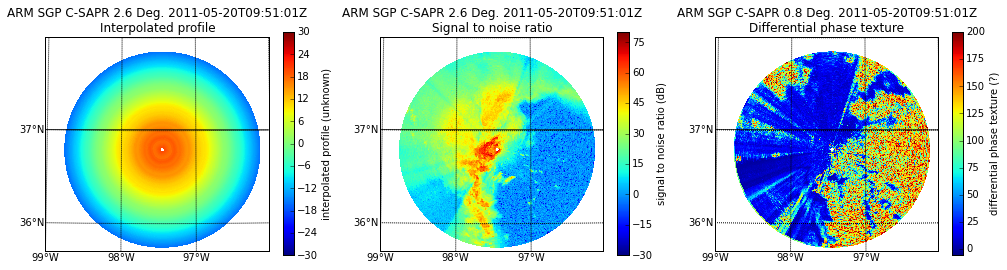

In [13]:
min_lon=-99.
max_lon=-96.
min_lat=35.7
max_lat=38.
lon_lines=[-95, -96, -97, -98, -99]
lat_lines=[35,36,37,38]

#create an instance of the class using our radar
display = pyart.graph.RadarMapDisplay(csapr_radar)
#create a Matplotlib figure
f = plt.figure(figsize = [17,4])
#now we are going to do a three panel plot, resolution is a basemap parameter and determines the resolution of 
#the coastline.. here we set to intermediate or 'i' ('h' for high 'l' for low)
plt.subplot(1, 3, 1) 
display.plot_ppi_map('sounding_temperature', sweep = 3, vmin = -30, vmax = 30,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')
plt.subplot(1, 3, 2) 
display.plot_ppi_map('SNR', sweep = 3, vmin = -30, vmax = 80,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')
plt.subplot(1, 3, 3) 
display.plot_ppi_map('differential_phase_texture', sweep = 0, vmax = 200,
                      min_lon = min_lon, max_lon = max_lon, min_lat = min_lat, max_lat = max_lat,
                     resolution = 'i')

In [14]:
second_trip = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
               'cross_correlation_ratio' : [[.5,.7,1,1], 0.0], 
               'normalized_coherent_power' : [[0,0,.5,.6], 3.0], 
               'height': [[0,0,5000,8000], 1.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[15,20, 1000,1000],1.0]}

rain = {'differential_phase_texture' : [[0,0,60,80], 1.0], 
               'cross_correlation_ratio' : [[0.97,0.98,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,5000,6000], 0.0], 
               'sounding_temperature' : [[0.,5.,100,100], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

snow = {'differential_phase_texture' : [[0,0,80,90], 1.0], 
               'cross_correlation_ratio' : [[0.85,0.9,1,1], 1.0], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 1.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,.1,4.], 2.0],
               'SNR' : [[8,10, 1000,1000], 1.0]}

no_scatter = {'differential_phase_texture' : [[90,90,400,400], 0.0], 
               'cross_correlation_ratio' : [[0,0,0.1,0.2], 0.0], 
               'normalized_coherent_power' : [[0,0,0.1,0.2], 0.0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-100,-100,100,100], 0.0],
               'SNR' : [[-100,-100, 8,10], 6.0]}

melting = {'differential_phase_texture' : [[30,40,80,90], 2.0], 
               'cross_correlation_ratio' : [[0.6,0.65,.92,.95], 4.], 
               'normalized_coherent_power' : [[0.4,0.5,1,1], 0], 
               'height': [[0,0,25000,25000], 0.0], 
               'sounding_temperature' : [[-2.,-1.,6,7], 1.],
               'SNR' : [[8,10, 1000,1000], 0.0]}

mbfs = {'multi_trip': second_trip, 'rain' : rain, 
        'snow' :snow, 'no_scatter' : no_scatter, 'melting' : melting}

hard_const = [['melting' , 'sounding_temperature', (10, 100)],
              ['multi_trip', 'height', (10000, 1000000)],
              ['melting' , 'sounding_temperature', (-10000, -7)]]


In [21]:
#hard_const = [['melting' , 'sounding_temperature', (6, 100)]]

gid_fld, cats = cum_score_fuzzy_logic(csapr_radar, mbfs = mbfs, debug = True, hard_const = hard_const)
csapr_radar.add_field('gate_id', fix_rain_above_bb(gid_fld, 3, 1, 5), 
                      replace_existing = True)

Doing no_scatter
Doing melting
Doing multi_trip
Doing rain
Doing snow
('Doing hard constraining ', 'melting')
(masked_array(data = [   0    0    0 ..., 6119 6119 6119],
             mask = False,
       fill_value = -9999.0)
, masked_array(data = [ 0  1  2 ..., 28 29 30],
             mask = False,
       fill_value = -9999.0)
)
('Doing hard constraining ', 'multi_trip')
(array([1800, 1800, 1800, ..., 6119, 6119, 6119]), array([966, 967, 968, ..., 972, 973, 974]))
('Doing hard constraining ', 'melting')
(masked_array(data = [1080 1080 1080 ..., 6119 6119 6119],
             mask = False,
       fill_value = -9999.0)
, masked_array(data = [806 807 808 ..., 972 973 974],
             mask = False,
       fill_value = -9999.0)
)


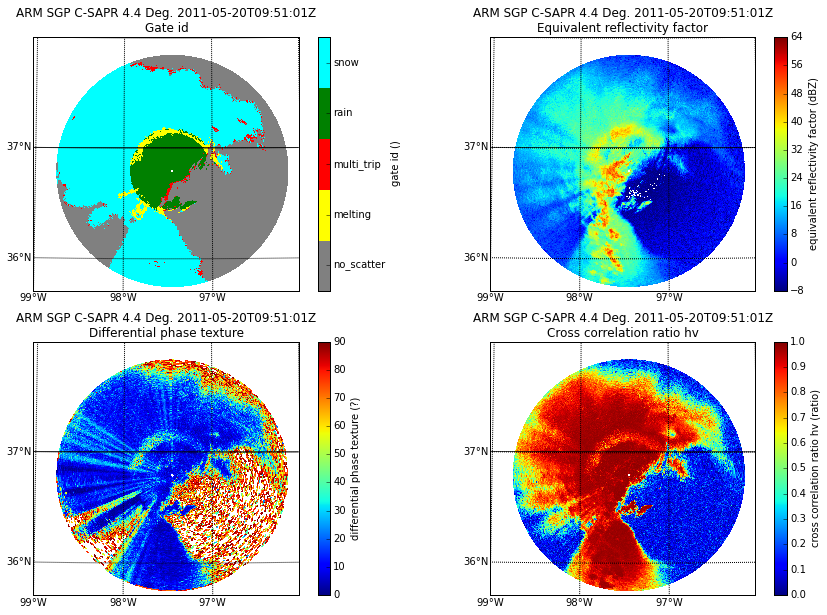

In [36]:
kwrgsss = {'sweep' : 5, 'min_lon' : min_lon, 'max_lon' : max_lon, 
           'min_lat' : min_lat, 'max_lat' : max_lat, 'resolution' : 'l'}
display = pyart.graph.RadarMapDisplay(csapr_radar)
f = plt.figure(figsize = [15,10])
plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', cmap = cmap, vmin = 0, vmax = 5, **kwrgsss)
cbax=plt.gca()
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
plt.subplot(2, 2, 2); display.plot_ppi_map('reflectivity',vmin = -8, vmax = 64, **kwrgsss)
plt.subplot(2, 2, 3); display.plot_ppi_map('differential_phase_texture', vmin =0, vmax = 90, **kwrgsss)
plt.subplot(2, 2, 4); display.plot_ppi_map('cross_correlation_ratio', vmin = 0, vmax = 1, **kwrgsss)


In [62]:
files = os.listdir('../data/')

good_files = []
for fl in files:
    if '.mdv' in fl:
        good_files.append(fl)

good_files.sort()
good_radars = []
for fl in good_files:
    csapr_radar = pyart.io.read('../data/'+fl)
    #lets trim some gates
    #plt.plot(csapr_radar.fields['reflectivity']['data'][0,975:])
    i_end = 975
    csapr_radar.range['data']=csapr_radar.range['data'][0:i_end]
    for key in csapr_radar.fields.keys():
        csapr_radar.fields[key]['data']= csapr_radar.fields[key]['data'][:, 0:i_end]
    csapr_radar.ngates = i_end
    csapr_radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
    csapr_radar.add_field('height', z_dict, replace_existing = True)
    phidp_text = pyart.retrieve.texture_of_complex_phase(csapr_radar)
    csapr_radar.add_field('differential_phase_texture', phidp_text, replace_existing = True)
    snr = pyart.retrieve.calculate_snr_from_reflectivity(csapr_radar)
    csapr_radar.add_field('SNR', snr, replace_existing = True)
    #hard_const = [['melting' , 'sounding_temperature', (6, 100)]]
    gid_fld, cats = cum_score_fuzzy_logic(csapr_radar, mbfs = mbfs, debug = False, hard_const = hard_const)
    csapr_radar.add_field('gate_id', fix_rain_above_bb(gid_fld, 3, 1, 5), 
                          replace_existing = True)
    good_radars.append(deepcopy(csapr_radar))
    print('Done ', fl)
                       


('Done ', '090036.mdv')
('Done ', '090736.mdv')
('Done ', '091436.mdv')
('Done ', '092136.mdv')
('Done ', '092836.mdv')
('Done ', '093536.mdv')
('Done ', '094236.mdv')
('Done ', '094936.mdv')
('Done ', '095636.mdv')


In [63]:
from JSAnimation import IPython_display
from matplotlib.animation import FuncAnimation


In [64]:
kwrgsss = {'sweep' : 3, 'min_lon' : min_lon, 'max_lon' : max_lon, 
           'min_lat' : min_lat, 'max_lat' : max_lat, 'resolution' : 'l'}

def update_radar(n):
    global fig, ax1, sx2, ax3, ax4, cmap
    display = pyart.graph.RadarMapDisplay(good_radars[n])
    ax1.cla()
    display.plot_ppi_map('gate_id', cmap = cmap, 
                         vmin = 0, vmax = 5, colorbar_flag = False, ax = ax1, **kwrgsss)
    ax2.cla()
    display.plot_ppi_map('reflectivity',vmin = -8, vmax = 64,
                         colorbar_flag = False, ax = ax2, **kwrgsss)
    ax3.cla()
    display.plot_ppi_map('differential_phase_texture', vmin =0, vmax = 90,
                         colorbar_flag = False, ax = ax3, **kwrgsss)
    ax4.cla()
    display.plot_ppi_map('cross_correlation_ratio', vmin = 0, vmax = 1,
                         colorbar_flag = False, ax = ax4,**kwrgsss)
    


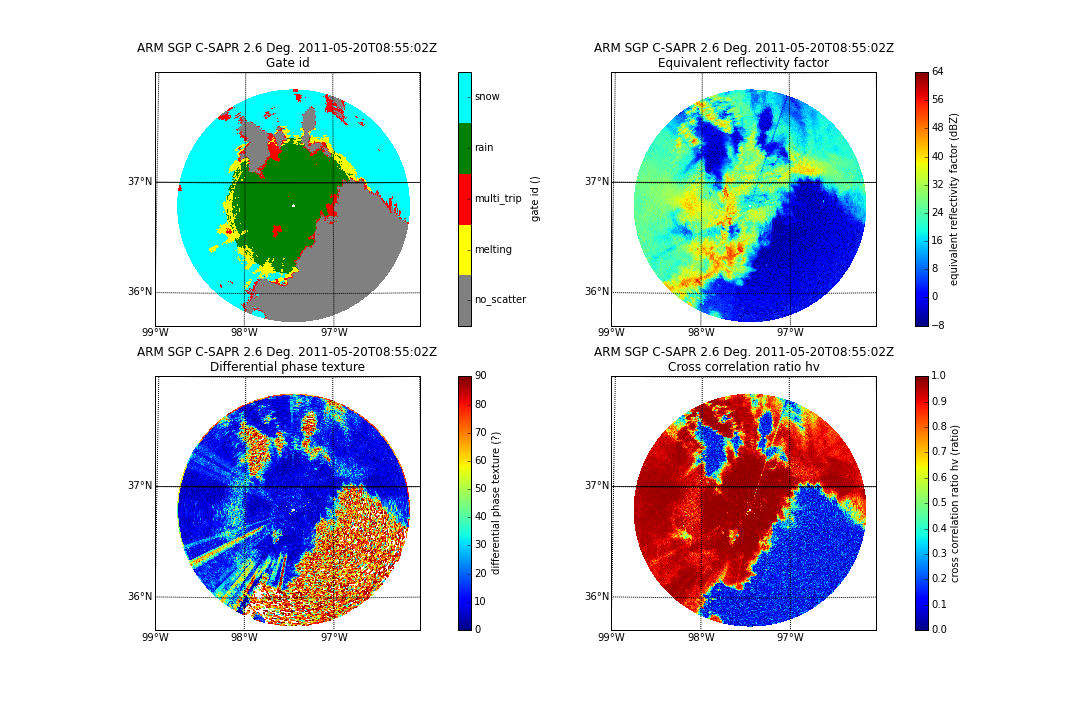
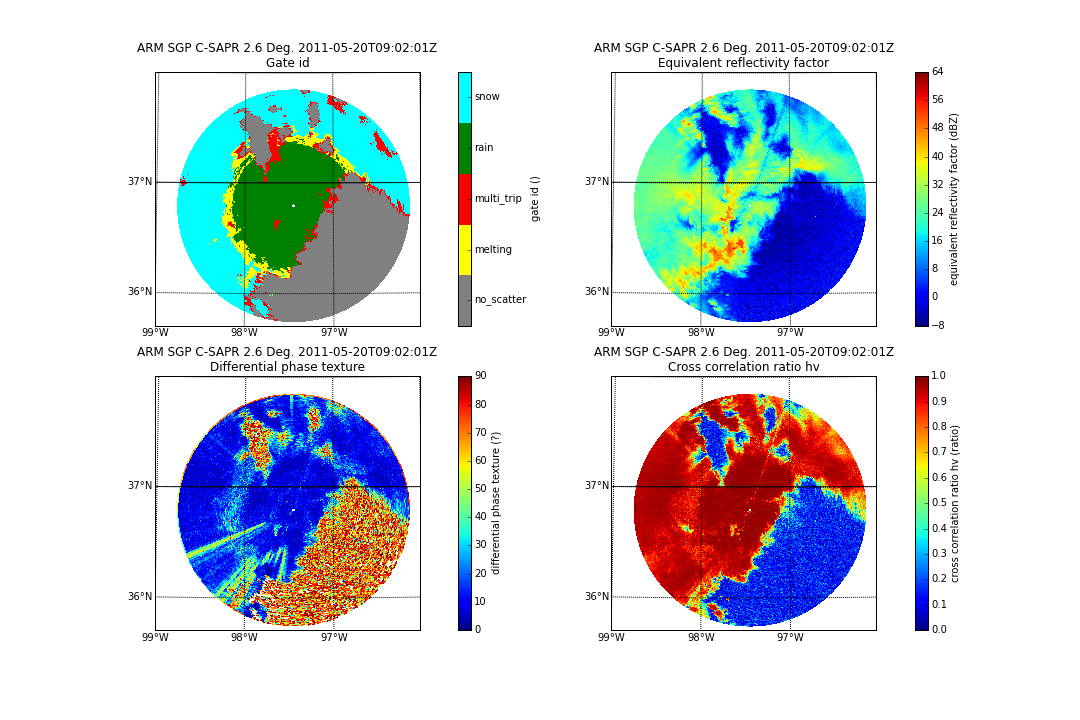
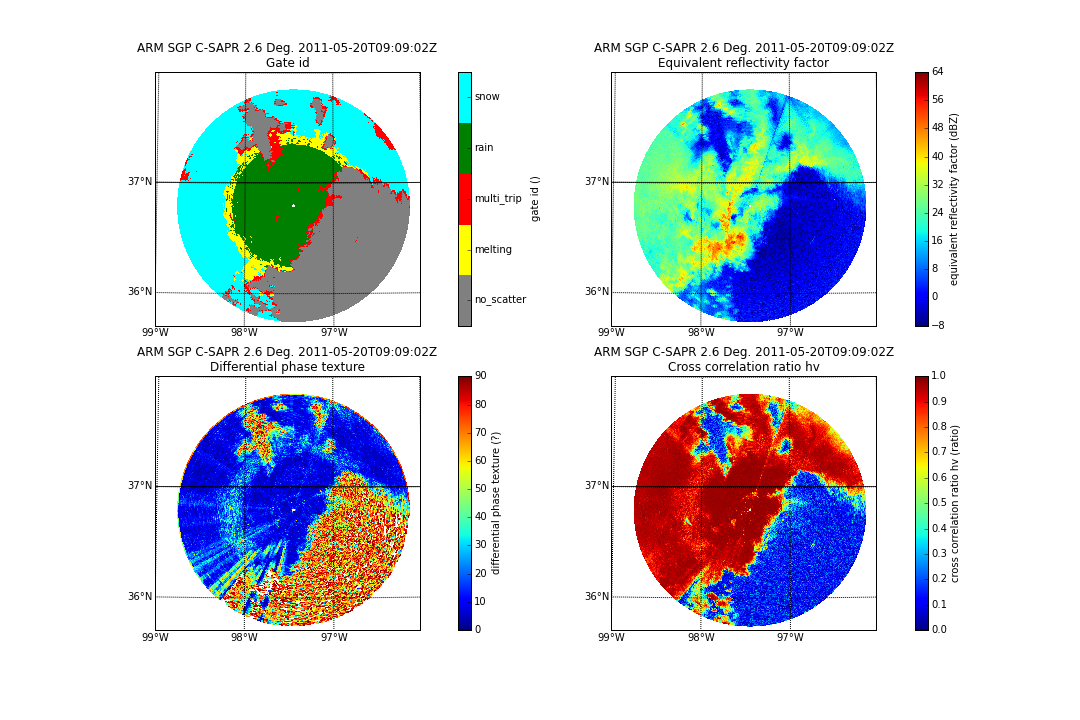
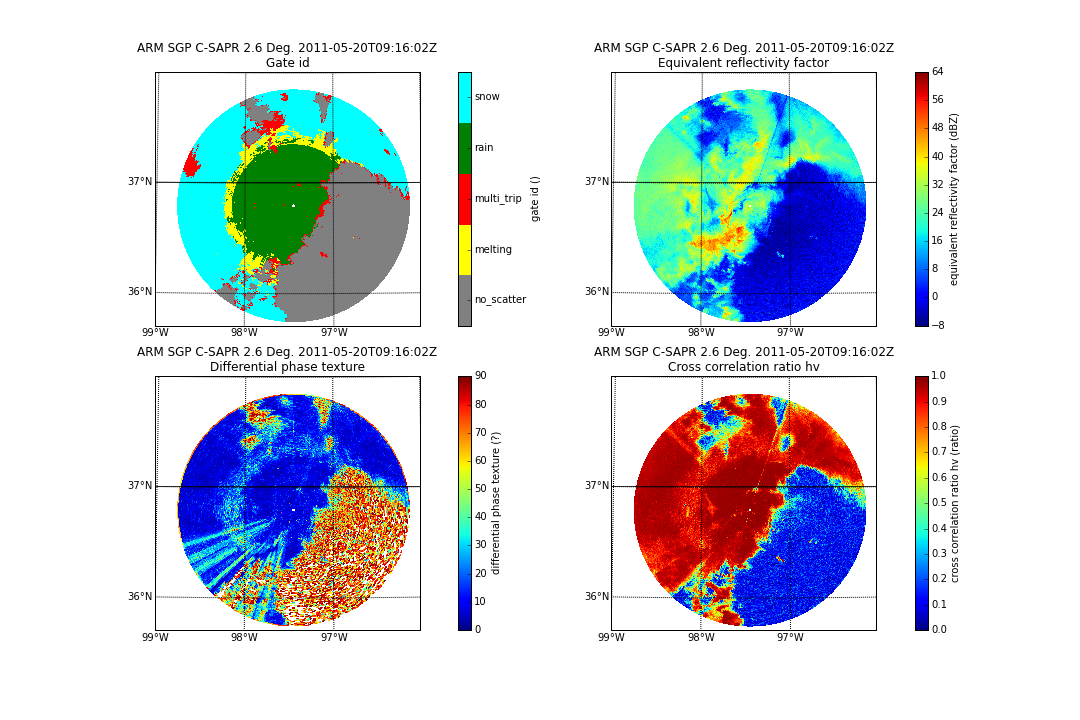
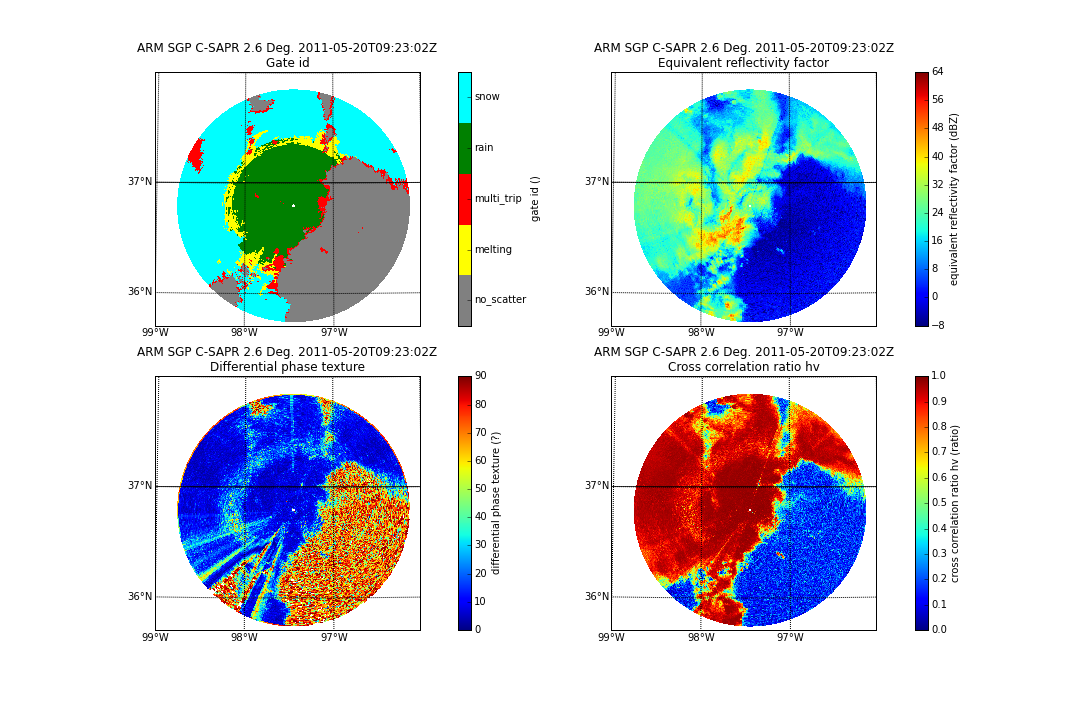
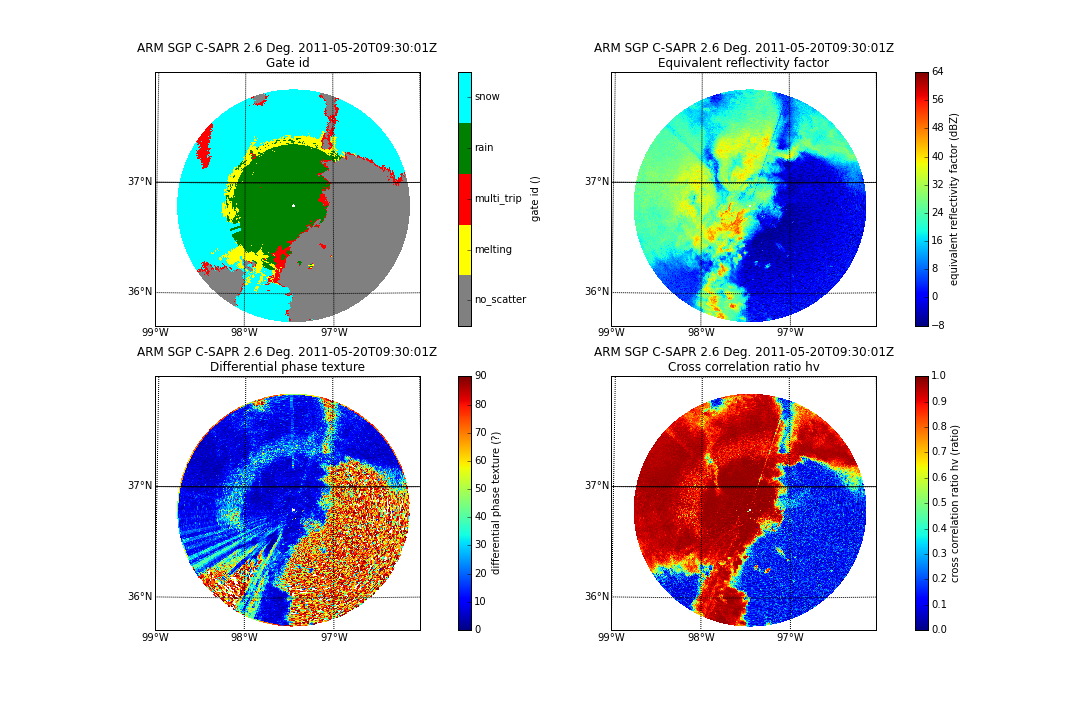
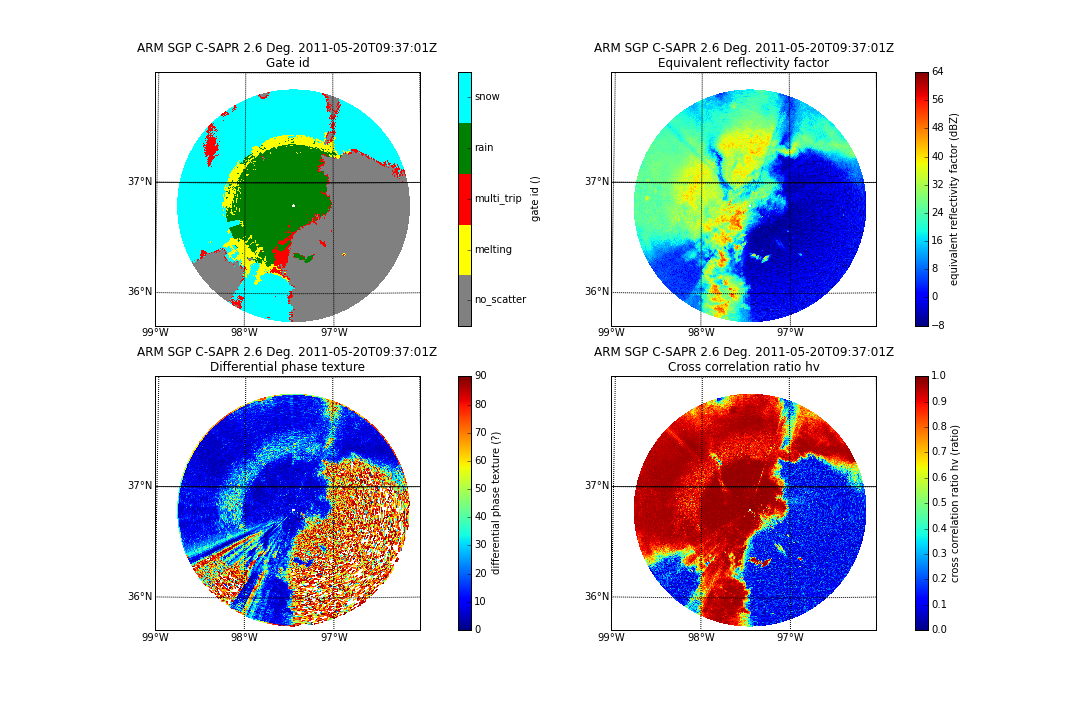
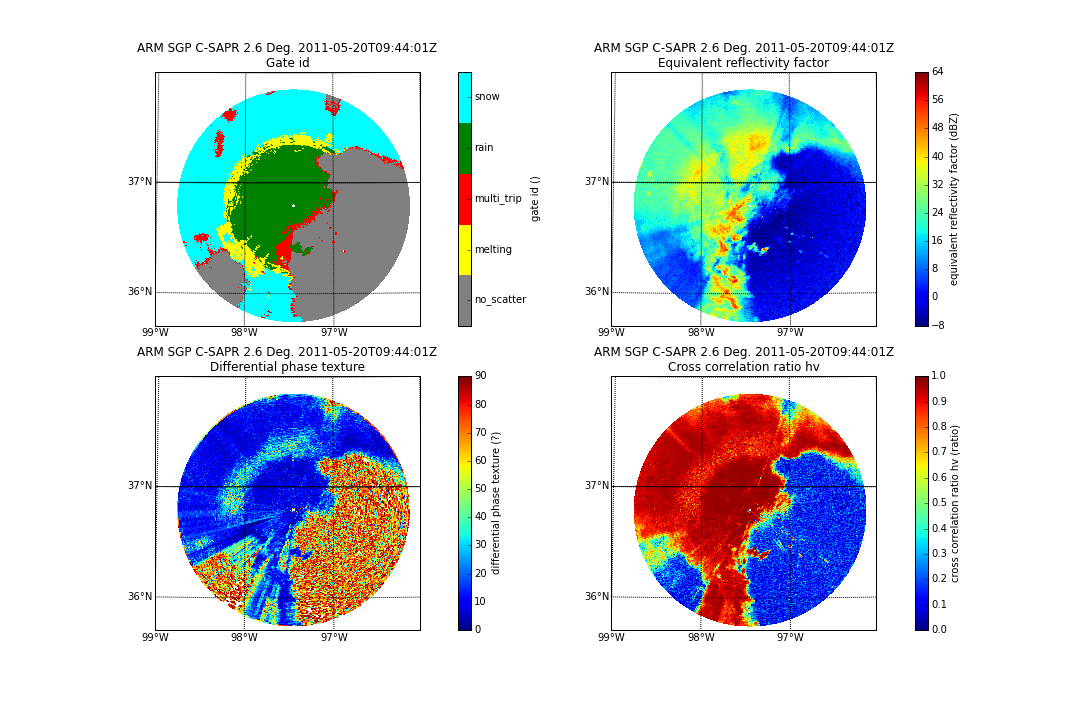
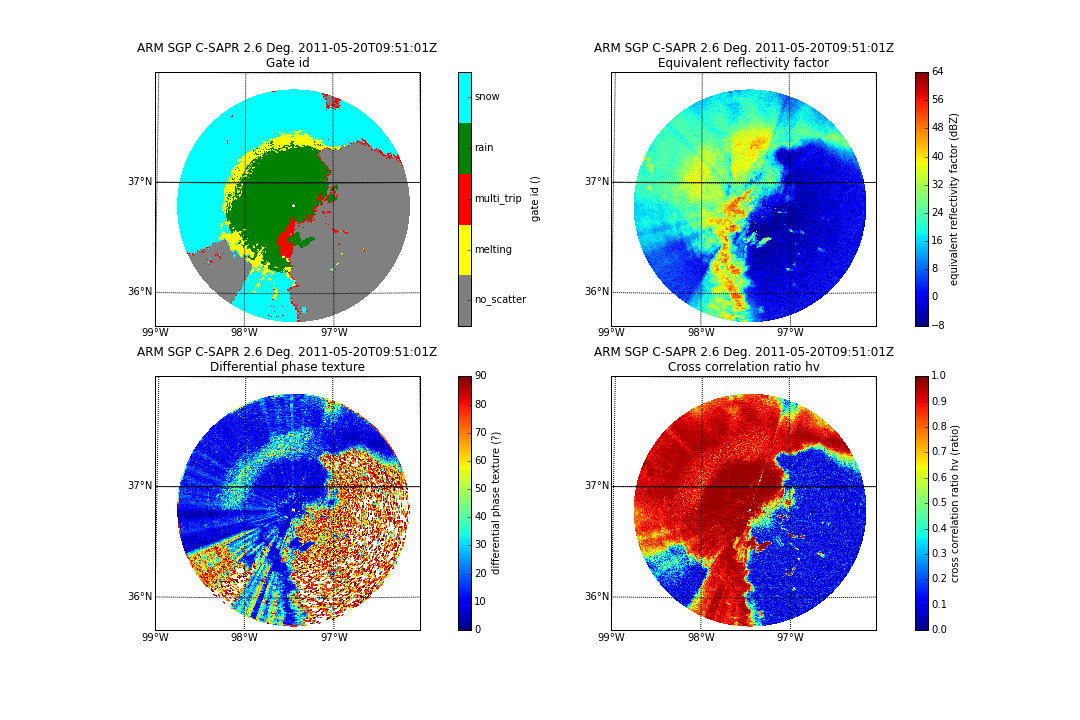

In [65]:
display = pyart.graph.RadarMapDisplay(good_radars[0])
fig = plt.figure(figsize = [15,10])
ax1 = plt.subplot(2, 2, 1) 
lab_colors=['gray','yellow', 'red', 'green', 'cyan' ]
cmap = colors.ListedColormap(lab_colors)
display.plot_ppi_map('gate_id', cmap = cmap, vmin = 0, vmax = 5, **kwrgsss)
cbax=plt.gca()
tick_locs   = np.linspace(0,len(cats) -1 ,len(cats))+0.5
display.cbs[-1].locator     = ticker.FixedLocator(tick_locs)
display.cbs[-1].formatter   = ticker.FixedFormatter(cats)
display.cbs[-1].update_ticks()
ax2 = plt.subplot(2, 2, 2); display.plot_ppi_map('reflectivity',vmin = -8, vmax = 64, **kwrgsss)
ax3 = plt.subplot(2, 2, 3); display.plot_ppi_map('differential_phase_texture', vmin =0, vmax = 90, **kwrgsss)
ax4 = plt.subplot(2, 2, 4); display.plot_ppi_map('cross_correlation_ratio', vmin = 0, vmax = 1, **kwrgsss)
FuncAnimation(fig, update_radar, interval=1000, frames= len(good_radars))

3:50-4:10
        room 204
Title:

From Zero to Hero in Two Years, Open Collaborative Radar Software and the Secret to our Success


Description:

As computer languages have undergone swift development in recent decades much of the oceanic and atmospheric community has been slow to shift from strongholds such as Fortran. While there has always been a number of open source solutions for the radar meteorology community to process data, projects have been stove-piped. Scientists tend to build applications on top of these software stacks in order to publish and the resultant code often is not used outside of the scientist’s institution or direct collaborators. This presentation will outline an alternate path using community based open source software. We will discuss the Python-ARM Radar Toolkit and recent community success in performing common radar processing tasks by combining multiple tools often written on different continents.


Presenter(s):
 	Scott Collis, Argonne National Laboratory
 	Nick Guy, University of Wyoming
 	Anderson Gama, SIMEPAR - Sistema Meteorológico do Paraná
 	Cesar Beneti, SIMEPAR - Sistema Meteorológico do Paraná
 	Stephen Nesbitt, University of Illinois
 	Scott Giangrande, Brookhaven National Laboratory
 	Maik Hiestermann, University of Potsdam
 	Kai Muehlbauer, University of Bonn




